# 1) Defining the problem.

In this project, I shall predict some movies box office. In order to do so, I'll use [The Movie Database's (TMDB) dataset](https://www.kaggle.com/c/tmdb-box-office-prediction/overviews), containing information like the movies' cast, release data, their original language, runtime and genra. Since I already have the revenue for the train dataset, it will be a *supervised* problem; therefore, some possible algorithms are linear regression models, KNeighbors regressors and Random Forest regressors.

# 2) Collecting the data

### Importing the dataset

In [1]:
# DataFrames and Arrays
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt
import seaborn as sns


# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Dimensionality reduction
from sklearn.preprocessing import StandardScaler # To use on X (features) before the PCA
from sklearn.decomposition import PCA

# Model selection
from sklearn import model_selection

# Performance metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error


# Other
import zipfile # To deal with zips
import ast # Parsing dictionary variables
import requests # Web scraping
import time # For the requests' sleep
from collections import Counter # Counts occurrences in dictionaries
import cpi # Inflation adjustments
from datetime import date

# Random seed
np.random.seed(0)

C:\Users\User\anaconda3\lib\site-packages\cpi\__init__.py:46: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  warnings.warn(StaleDataWarning())


**Note on the CPI package:** since the [CPI package](https://github.com/datadesk/cpi) has, by today's (2020-12-18) default, the USA inflation data until nov/2019,  and as we're inflation adjusting our data in this project until aug/2018, there's no need to  run "cpi.update()" here. Indeed, this line of code would even slow down your execution.

In [2]:
# The datasets
zf = zipfile.ZipFile('datasets/tmdb-box-office-prediction.zip') 
train = pd.read_csv(zf.open('train.csv'))
test = pd.read_csv(zf.open('test.csv'))

In [3]:
# Handling columns that are JSON objects
dict_cols = ['genres', 'production_companies', 'production_countries', 'cast', 'crew']

def text_to_dict(df):
    """ Transforms JSON columns from strings to dictionaries """
    for col in dict_cols:
        df[col] = df[col].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

for df in [train, test]:
    df = text_to_dict(df)

In [4]:
print("Shape of the train dataset: ", train.shape)
print("Shape of the test dataset: ", test.shape)

Shape of the train dataset:  (3000, 23)
Shape of the test dataset:  (4398, 22)


Note that the test dataset is larger than the train set, which is unusual. Also, the test dataset does not contain any information on the target variable (the movies' revenue). Let's take a look first at the train dataset.

In [5]:
# A brief look at the data
train.head() # First five observations

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [6]:
train.info() # Variable types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 3000 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   3000 non-null   object 
 12  production_countries   3000 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

Note that *release_date* variable was compiled as an "object" type (ie, probably a *string* variable), instead of *datetime*. All other variables are assigned to their correct types. It will be corrected further on.


## Filling Test's revenues and merging it to Train dataset

In order to increase the number of observations, I will scrap the revenue values of the movies from 'test' dataset using the TMDB's Application Programming Interface (API) and, subsequently, merge both train and test datasets into a single "complete" dataset. The train-test split will then be done later on, using this complete dataset.

### TMDB's API

The TMDB's API is a free interface which only requires you to create an account in order to use it. Once you're all set, you can perfom "GET" requests using, for instance, the Python's "request" package. The request will return a JSON object, which is nothing more than a string object containing dictionaries of elements. The JSON object can then be parsed (interpreted) thereafter using requests' ".json()" method.

Unfortunately, the movies' TMDB ids are required to obtain the movies' revenues, and they are not directly available from our datasets. However, it is possible to return them perfoming requests using the TMDB API's "find" method.

In [7]:
def get_TMDB_id(imdb_id, api_key):
    """ Returns the tmdb_id for a given imdb_id, using TMDB API's "find" method
    
    imdb_id: self-explanatory
    api_key: your TMDB API key.
    """
    url = "https://api.themoviedb.org/3/find/" + imdb_id

    # The parameters to be used on the request
    querystring = {"api_key": api_key,
                   "language":"en-US",
                   "external_source":"imdb_id"}
    
    # Making the request and parsing its text from JSON format to Python's dictionaries
    response = requests.request("GET", url, params=querystring)
    parsed_response = response.json()
    
    # Getting the tmdb_id
    tmdb_id = parsed_response['movie_results'][0]['id']
    
    return str(tmdb_id)


def get_revenue(tmdb_id, api_key):
    """ Given the movie's tmdb_id, returns its revenue, using TMDB API's "movie" method
    
    tmdb_id: self-explanatory
    api_key: your TMDB API key
    """
    url = "https://api.themoviedb.org/3/movie/" + tmdb_id

    querystring = {"api_key": api_key}

    # Getting the request object
    response = requests.request("GET", url, params=querystring)

    # Parsing the information we want
    parsed_response = response.json()
    revenue = parsed_response['revenue']
    
    return revenue

In [8]:
# Creating lists to receive the imdb_ids and also the revenues
test_imdb_ids = [x for x in test['imdb_id']]
the_revenues = [0] * len(test_imdb_ids)
# api_key = "" # YOUR API_KEY HERE

Now, let's make the requests. It is worth noting that you will need your own API key in order to do so. Also, it is highly recommended to do a limited number of requests *per minute* to avoid overloading the system and, hence, being banned from it. I'll limit them to 20 *per minute*. 

Finally, note also that this procedure will take approximately 7 hours to be done.

In [9]:
# WARNING: the following code chunk requires a TMDB API key (which you can get for free on their website)
# It also takes about 7 hours to run. If you __REALLY__ want to run it, replace "if False:" on the following
# line of code to "if True:"

if False:
    for i in range(len(test_imdb_ids)):
        # Fill the values
        print(i)
        try:
            next_tmdb_id = get_TMDB_id(test_imdb_ids[i], api_key)
            the_revenues[i] = get_revenue(next_tmdb_id, api_key)
        except:
            print("An error occurred on observation ", i)

        # Avoids excessive requests
        # After 20 requests, stops the execution for one minute
        # (remember: each loop counts as 2 requests)
        if (i + 1) % 10 == 0:
            print("Step: ", i)
            time.sleep(60)

    print("\nDone!")
    
    # Saving the revenue values to a file
    #pd.DataFrame(the_revenues).to_excel('test_revenues.xlsx', header=True, index=False)

Loading the file

In [10]:
test['revenue'] = pd.read_excel('datasets/test_revenues.xlsx')

Dropping the movies for which the information on the revenue was not available, and merging the dataframes thereafter.

In [11]:
test = test.drop(test[test.revenue == 0].index) # drops those movies for which the REVENUE was not available
drop_list = test.loc[test['release_date'] != test['release_date']].index[0]
test.drop([drop_list], axis = 0, inplace = True) # drops movies without RELEASE DATA info (only one)


# Merging the dataframes into a single df.
frames = [train, test]
complete_df = pd.concat(frames)

# Replaces budget == 0 with NaN
complete_df['budget'] = complete_df['budget'].replace(0.0, np.nan) # Replacing 0 with NaN

In [13]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7344 entries, 0 to 4397
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     7344 non-null   int64  
 1   belongs_to_collection  1472 non-null   object 
 2   budget                 5338 non-null   float64
 3   genres                 7344 non-null   object 
 4   homepage               2346 non-null   object 
 5   imdb_id                7344 non-null   object 
 6   original_language      7344 non-null   object 
 7   original_title         7344 non-null   object 
 8   overview               7322 non-null   object 
 9   popularity             7344 non-null   float64
 10  poster_path            7343 non-null   object 
 11  production_companies   7344 non-null   object 
 12  production_countries   7344 non-null   object 
 13  release_date           7344 non-null   object 
 14  runtime                7338 non-null   float64
 15  spok

## Data Prep

#### Date variables

It is worth noting that the competition was supposed to conclude May 30, 2019. Therefore, all movies with year greater than 19 are from the last century, consequently.

In [14]:
def gen_year(x):
    """ Returns the year from the date.
    
    PS: the release date was originally a STRING on the mm/dd/yy format
    """
    year = x.split('/')[2]
    year = int(year)
    return year

##### Year

Creating the year variable

In [15]:
# Creating the YEAR variable
complete_df['year'] = 0
complete_df['year'] = complete_df['release_date'].apply(lambda x: gen_year(x))

In [16]:
# Counting the occurrences of years between 1920 and 1930
print("Absolute frequency of movies with release dates between 1920 and 1930")
complete_df.loc[(complete_df['year'] <= 30) & (complete_df['year'] >= 20)]['year'].value_counts()

Absolute frequency of movies with release dates between 1920 and 1930


25    6
28    5
27    3
30    2
26    2
29    1
24    1
23    1
22    1
21    1
Name: year, dtype: int64

As there are almost no movies in the dataset from 1930 or older, it is reasonable to label all movies with year ending in 19 or below as 21th century movies.

In [17]:
def fix_year_release_date(release_date):
    """ Adds 1900 or 2000 to the 'release_date' variable's year"""
    year = release_date.split('/')[2] # Picks the year
    
    # Corrects the year
    if int(year) <= 19:
        return release_date[:-2] + '20' + year
    else:
        return release_date[:-2] + '19' + year

In [18]:
# Corrects the 'year' column
complete_df['year'] = complete_df['year'].apply(lambda x: 1900 + x if x > 19 else 2000 + x)

##### Release date

In [19]:
# Corrects the 'release_date' column
complete_df['release_date'] = complete_df['release_date'].apply(lambda x: fix_year_release_date(x))
complete_df['release_date'] = pd.to_datetime(complete_df['release_date'])

##### Quarter and weekday

I tried also using release months instead of release quarters, but there was almost no performance improvements on cross-validation. Thus, I opted for the quarters.

In [20]:
complete_df['release_quarter'] = complete_df['release_date'].dt.quarter
complete_df = pd.get_dummies(complete_df, columns=['release_quarter'], drop_first = True)
complete_df['release_quarter'] = complete_df['release_date'].dt.quarter

complete_df['release_weekday'] = complete_df['release_date'].dt.weekday
complete_df['release_weekday_friday'] = complete_df['release_weekday'].apply(lambda x: int(1) if x == 4 else int(0))

In [21]:
# Monday == 0, Friday == 4, Sunday == 6
complete_df['release_weekday'].head()

0    4
1    4
2    4
3    4
4    3
Name: release_weekday, dtype: int64

In [22]:
complete_df.loc[complete_df['id'] == 1283]['release_date']

1282   1969-12-18
Name: release_date, dtype: datetime64[ns]

#### Revenue and Budget

Adjusting the values for inflation and creating the natural log version of the variables:

In [23]:
# Getting the most recent movie release date
max_date = complete_df['release_date'].max()

# Inflation adjusting
complete_df['revenue'] = complete_df.apply(lambda x: cpi.inflate(value = x.revenue, year_or_month = x.release_date, to = max_date), axis = 1)
complete_df['budget'] = complete_df.apply(lambda x: cpi.inflate(value = x.budget, year_or_month = x.release_date, to = max_date), axis = 1)

# log1p(x) = ln(x+1): it avoids calculating log(0), which is undefined
complete_df['ln_revenue'] = complete_df['revenue'].apply(lambda x: np.log1p(x))
complete_df['ln_budget'] = complete_df['budget'].apply(lambda x: np.log1p(x))

#### Popularity

As popularity has a skewed distribution, we shall create log popularity. I've also tested using (popularity, popularity^2, popularity^3 and popularity^4) against log popularity, and the latter perfomed better in all metrics.

In [51]:
complete_df['ln_popularity'] = complete_df['popularity'].apply(lambda x: np.log1p(x))

#### Runtime variable

There are about 30 movies without their runtime information, or with 0 (zero) minutes runtime, which is almost the same, since it is virtually impossible for a movie to be less than one minute long. However, all of this can be easily fixed by searching on IMDB.

In [52]:
# Finding out the movies with NaN (missing data) on runtime variable
complete_df['runtime'] = complete_df['runtime'].replace(0.0, np.nan) # Replacing 0 with NaN
complete_df.loc[complete_df['runtime'] != complete_df['runtime'], ['id', 'title', 'runtime', 'imdb_id']]

,id,title,runtime,imdb_id
390,391,The Worst Christmas of My Life,NaN,tt2550838
591,592,А поутру они проснулись,NaN,tt0768690
924,925,¿Quién mató a Bambi?,NaN,tt2604346
977,978,La peggior settimana della mia vita,NaN,tt2076251
1255,1256,"Cry, Onion!",NaN,tt0072785
1335,1336,Королёв,NaN,tt1107828
1541,1542,All at Once,NaN,tt3805180
1874,1875,Missing,NaN,tt1133617
2150,2151,Mechenosets,NaN,tt0477337
2302,2303,Happy Weekend,NaN,tt0116485


In [53]:
# Filling the runtime's missing values with IMDB's information
complete_df.loc[complete_df['id'] == 1336,'runtime'] = 130 # Korolyov
complete_df.loc[complete_df['id'] == 3244,'runtime'] = 93 # La caliente niña Julietta
complete_df.loc[complete_df['id'] == 4490,'runtime'] = 91 # Pancho, el perro millonario
complete_df.loc[complete_df['id'] == 4633,'runtime'] = 100 # Nunca en horas de clase
complete_df.loc[complete_df['id'] == 6818,'runtime'] = 90 # Miesten välisiä keskusteluja
complete_df.loc[complete_df['id'] == 391,'runtime'] = 96 # The Worst Christmas of My Life
complete_df.loc[complete_df['id'] == 978,'runtime'] = 93 # La peggior settimana della mia vita
complete_df.loc[complete_df['id'] == 1542,'runtime'] = 93 # All at Once
complete_df.loc[complete_df['id'] == 2151,'runtime'] = 108 # Mechenosets
complete_df.loc[complete_df['id'] == 2303,'runtime'] = 90 # Happy Weekend (1996)
complete_df.loc[complete_df['id'] == 2499,'runtime'] = 86 # Hooked on the Game 2. The Next Level
complete_df.loc[complete_df['id'] == 2866,'runtime'] = 96 # Tutto tutto niente niente
complete_df.loc[complete_df['id'] == 4074,'runtime'] = 103 # Shikshanachya Aaicha Gho
complete_df.loc[complete_df['id'] == 4431,'runtime'] = 96 # Plus one
complete_df.loc[complete_df['id'] == 5520,'runtime'] = 86 # Glukhar v kino
complete_df.loc[complete_df['id'] == 5849,'runtime'] = 140 # Shabd
complete_df.loc[complete_df['id'] == 6210,'runtime'] = 104 # The Last Breath

complete_df.loc[complete_df['id'] == 592,'runtime'] = 90 # A poutru oni prosnulis
complete_df.loc[complete_df['id'] == 925,'runtime'] = 86 # Quién mató a Bambi?
complete_df.loc[complete_df['id'] == 1256,'runtime'] = 92 # Confusão em Paraíso City
complete_df.loc[complete_df['id'] == 1875,'runtime'] = 86 # Missing
complete_df.loc[complete_df['id'] == 2646,'runtime'] = 98 # My Old Classmate
complete_df.loc[complete_df['id'] == 2786,'runtime'] = 111 # Revelation
complete_df.loc[complete_df['id'] == 4222,'runtime'] = 91 # Street Knight
complete_df.loc[complete_df['id'] == 5845,'runtime'] = 83 # Frau Müller muss weg!
complete_df.loc[complete_df['id'] == 6804,'runtime'] = 140 # Chaahat Ek Nasha...
complete_df.loc[complete_df['id'] == 7321,'runtime'] = 84 # El truco del manco

#### Crew and cast

For the crew and cast, we'll create a variable for each with their size, and also a dummy variable "top_50", which takes 1 if the movie contains at least one of the top 50 most recurrent cast/crew member in the dataset, and 0 elsewise.

In [54]:
class json_variables(object):
    """ Handles JSON (ie, dictionary) variables. """
    
    def __init__(self, df, variable, top_number):
        """ Initiates the class.
        
        df: dataframe.
        variable: the variable of interest (cast, crew, prod.companies, prod. countries or genre.)
        top_number: threshold. Example: top_number = 30 means it will consider only the 30
        most frequent cast / crew members / etc in the dataframe
        """
        self.df = df
        self.variable = variable
        self.top_number = top_number
        
        # Creates a list with each observation from that variable
        self._list_of_obs = list(df[variable].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
        
        # Counts the number of occurrences for the top "top_number" cast / crew members on the df,
        # (dictionary-like list, with tuples containing the names followed by their counter)
        self.top_variable = Counter([i for j in self._list_of_obs for i in j]).most_common(top_number)
        
        # Grab only the cast / crew names, without their occurrences counter
        self.top_variable_names = [x[0] for x in self.top_variable]

        
        return None

    
    def method(self, select):
        """ Selects whether to call "generate_counter_var" or "generate_dummies"
        
        select: selected method name (counter, dummy)
        """
        if (select != "counter") and (select != "dummy"):
            raise ValueError("Error. Selection variable must be either 'counter' or 'dummy'")
        
        # Getting rid of "self"
        variable = self.variable
        top_number = self.top_number
        
        # Creates new df to add the brand new variable
        new_df = self.df
        
        # Creates a new string variable containing all the crew / cast members on df
        new_df[variable + '_all'] = new_df[variable].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
        
        
        # Selection
        if select == "counter":
            new_df = self.generate_counter_var(variable, top_number, new_df)
        else: # ie, if select == "dummy"
            new_df = self.generate_dummies(variable, top_number, new_df)
            

        # Removes support variables created
        new_df.drop([variable + '_all'], axis = 1, inplace = True)
        
        return new_df
    
    
    def generate_counter_var(self, variable, top_number, new_df):
        """ Adds a variable to the df counting how many "top_number" cast / crew members are there on each movie. 
        
        new_df: copy from the original df
        """
    
        def occurrence_counter(df_variable, list_of_names):
            """ Counts number of famous cast / crew members on each movie """
            occurrences = 0
            
            for person in list_of_names:
                if person in df_variable:
                    occurrences += 1
                    
            return occurrences
        
        # Applies the previously defined function
        new_df[variable + '_top_' + str(top_number) + '_counter'] = 0
        new_df[variable + '_top_' + str(top_number) + '_counter'] = new_df[variable + '_all'].apply(lambda x: occurrence_counter(x, self.top_variable_names))
        
        return new_df
    
    
    def generate_dummies(self, variable, top_number, new_df):
        """ Creates dummies taking account if the movie belongs to the "top_number"
        genra / or was developed by the "top_number" company
        """
        # Creates dummy variables
        for entry in self.top_variable_names:
            new_df[variable + '_' + entry] = complete_df[variable + '_all'].apply(lambda x: 1 if entry in x else 0)
            
        return new_df

In [55]:
# Size
for variable in ['crew', 'cast']:
    complete_df[variable + '_size'] = complete_df[variable].apply(lambda x: len(x))

# Top_50 dummies
for variable in ['cast', 'crew']:
    my_object = json_variables(complete_df, variable, 50)
    complete_df = my_object.method(select = "counter")

#### Production Countries, production companies and genra

For all these three variables, we will create variables counting their occurrences. For production companies, we'll also create dummy variables for the top 10 most common occurrences. For production countries, we'll do something different, however.

In [56]:
# Renaming "production" to "prod", for the sake of simplicity
complete_df.rename(columns={"production_countries": "prod_countries", "production_companies": "prod_companies"}, inplace = True)

# Counter
for variable in ['prod_countries', 'prod_companies', 'genres']:
    complete_df[variable + '_count'] = complete_df[variable].apply(lambda x : len(x))

In [57]:
# Production companies and genres dummies
for variable in ['prod_companies', 'genres']:
    if variable == 'prod_companies':
        x = 11
    else:
        x = 10
    my_object = json_variables(complete_df, variable, x)
    complete_df = my_object.method(select = "dummy")

Since all movies from "Columbia Pictures Corporation" are also counted as "Columbia Pictures" movies, we'll drop the first.

In [58]:
# Since all movies from "Columbia Pictures Corporation" are also counted as "Columbia Pictures" movies, we'll drop the first.
complete_df.drop(['prod_companies_Columbia Pictures Corporation'], axis = 1, inplace = True)

Also, since more than half of the movies were produced in the United States, I'll create a dummy for it. Furthermore, I'll create a dummy for the movie being produced in at least one of the other top 9 most common countries. Note that a movie may be produced in more than one country.

In [59]:
my_object = json_variables(complete_df, 'prod_countries', 10)
top_10_countries = my_object.top_variable_names

# United States dummy
complete_df['prod_countries_all'] = complete_df['prod_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
complete_df['prod_countries_USA'] = complete_df['prod_countries_all'].apply(lambda x: 1 if 'United States of America' in x else 0)


def produced_on_other_top_10(x, top_10_countries):
    """ Returns 1 if the movie was produced in at least one of the other top 10
    most common countries, and 0 otherwise
    """
    # Excludes USA from the list
    other_top_10_countries = top_10_countries[1:]
    
    for country in other_top_10_countries:
        if country in x:
            return 1
        else:
            pass
    
    return 0


# Other top 10 countries dummy:
complete_df['prod_countries_other_top_10'] = complete_df['prod_countries_all'].apply(lambda x: produced_on_other_top_10(x, top_10_countries))

#### Homepage variable

It is worth noting that about two-thirds of the movies have no homepage. Perhaps, this may be itself an useful piece of information. Let's check it.

In [60]:
# Creates a variable for having a homepage
complete_df['has_homepage'] = 0
complete_df.loc[complete_df['homepage'].isnull() == False, 'has_homepage'] = 1

In [61]:
complete_df['has_homepage'].value_counts() # Counts the occurrences

0    4998
1    2346
Name: has_homepage, dtype: int64

#### Belongs to collection

As with the homepage information, I created a dummy for whether the movie belongs to a collection or not.

In [62]:
complete_df['has_collection'] = complete_df['belongs_to_collection'].apply(lambda x: int(0) if x != x else int(1))

#### Status variable

Last, but not least, for some reason, there are four movies labeled as "rumored" or in "post production" (*ie*, not yet released). 

In spite of this, all of them have revenues values. Furthermore, when checking on the internet, one will find that all of them have been released, indeed. Hence, as only a minimal fraction of the movies are labeled as something other than "released", it is reasonably safe to drop this feature without loss of generality.

In [63]:
complete_df['status'].value_counts()

Released           7332
Rumored               6
Post Production       5
Name: status, dtype: int64

In [64]:
complete_df[complete_df['status'] != 'Released'][['title','status','release_date','revenue']]

,title,status,release_date,revenue
609,The Swan Princess: Escape from Castle Mountain,Rumored,1997-01-01,4.336784e+05
1007,Billy Gardell: Halftime,Rumored,2011-02-05,6.836035e+01
1216,Extremities,Rumored,1986-08-22,3.084155e+07
1618,A Place Called Chiapas,Rumored,1998-02-20,3.566488e+05
102,"Good Morning, Babylon",Rumored,1987-05-13,4.095422e+05
264,The Last Mountain,Post Production,2011-06-03,1.010105e+05
847,Good Time,Post Production,2017-08-11,3.371993e+06
1056,Stevie,NaN,2002-09-09,1.351280e+05
1260,What Maisie Knew,Post Production,2013-05-02,1.154377e+06
1448,Crimes of the Heart,Post Production,1986-12-12,5.226729e+07


## Exploratory Data Analysis (EDA)

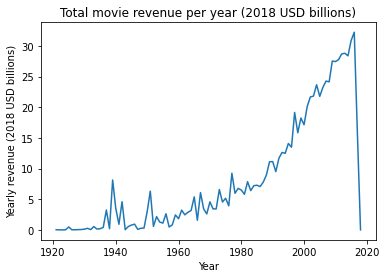

In [65]:
df1 = complete_df.groupby('year', as_index=False)['revenue'].sum()
df1['revenue_usd_billion'] = df1['revenue'].apply(lambda x: x / 1000000000)

sns.lineplot(x="year", y = "revenue_usd_billion", data = df1)
plt.title("Total movie revenue per year (2018 USD billions)")
plt.xlabel("Year")
plt.ylabel("Yearly revenue (" +  str(max_date.year) + " USD billions)")
plt.show()

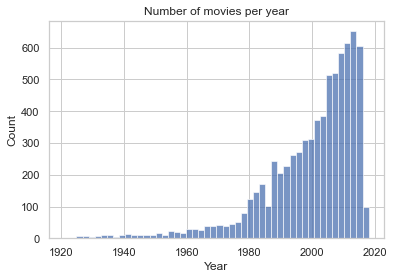

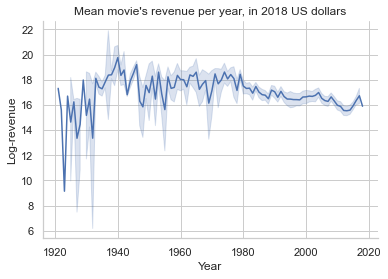

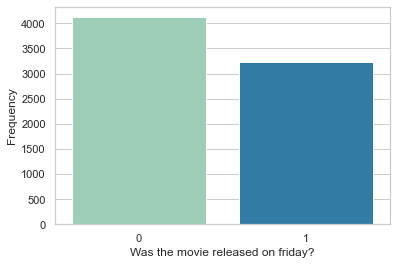

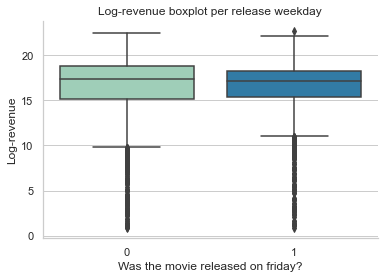

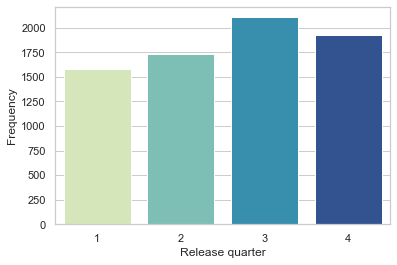

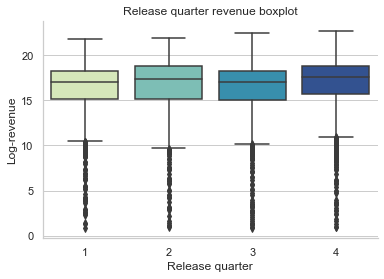

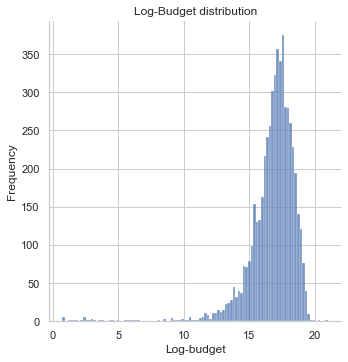

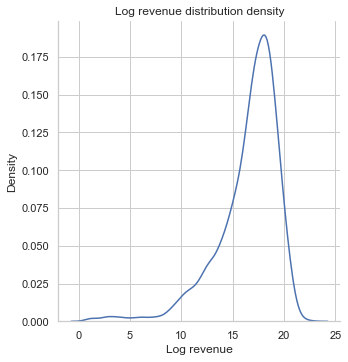

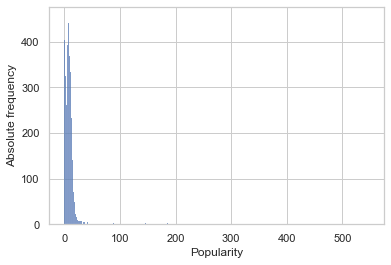

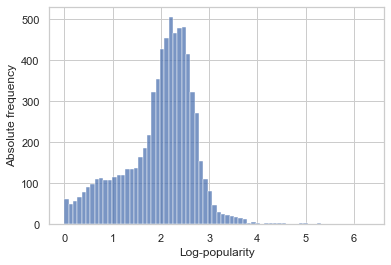

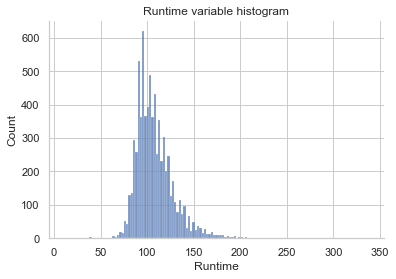

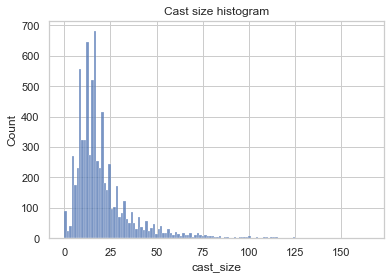

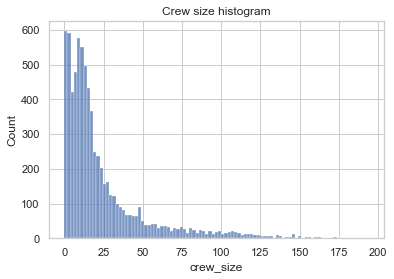

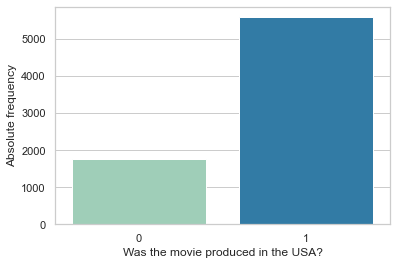

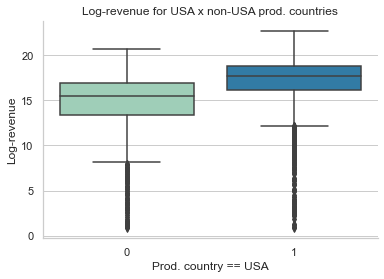

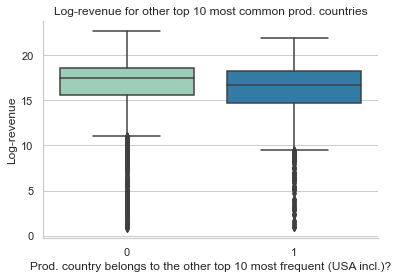

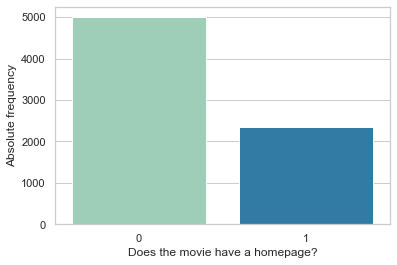

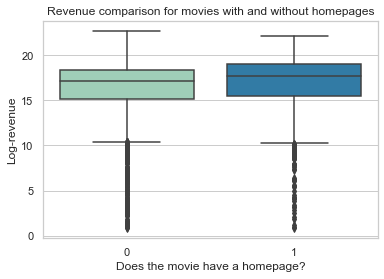

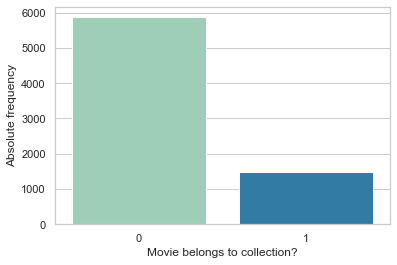

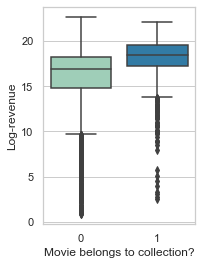

In [66]:
################ DATE VARIABLES
# Year
sns.set_theme(style="whitegrid")
plt.xlabel("Year")
plt.title("Number of movies per year")
sns.histplot(data = complete_df, x = "year")
plt.show()

sns.lineplot(x="year", y="ln_revenue", data=complete_df)
sns.despine() # Removes some of the borders
plt.ylabel("Log-revenue")
plt.xlabel("Year")
my_label = "Mean movie's revenue per year, in " + str(max_date.year) + " US dollars"
plt.title("Mean movie's revenue per year, in " + str(max_date.year) + " US dollars")
plt.show()


# Released on friday?
sns.set_theme(style="whitegrid")
sns.countplot(data = complete_df, x = "release_weekday_friday", palette = "YlGnBu").set(xlabel = "Was the movie released on friday?", ylabel = "Frequency")
plt.show()

sns.boxplot(x="release_weekday_friday", y="ln_revenue", data=complete_df, palette = "YlGnBu")
plt.xlabel("Was the movie released on friday?")
plt.ylabel("Log-revenue")
plt.title("Log-revenue boxplot per release weekday")
sns.despine()
plt.show()

# Quarter
sns.set_theme(style="whitegrid")
sns.countplot(data = complete_df, x = "release_quarter", palette = "YlGnBu").set(xlabel= "Release quarter", ylabel = "Frequency")
plt.show()

sns.boxplot(x="release_quarter", y="ln_revenue", data=complete_df, palette = "YlGnBu").set(xlabel= "Release quarter", ylabel = "Log-revenue")
plt.title("Release quarter revenue boxplot")
sns.despine()
plt.show()


###################### BUDGET, REVENUE AND POPULARITY
sns.displot(data = complete_df, x = "ln_budget").set(xlabel= "Log-budget", ylabel = "Frequency", title = "Log-Budget distribution")
plt.show()

sns.displot(x = 'ln_revenue', data = complete_df, kind = 'kde')
plt.title("Log revenue distribution density")
plt.xlabel("Log revenue")
plt.show()


sns.histplot(data = complete_df, x='popularity')
plt.ylabel("Absolute frequency")
plt.xlabel("Popularity")
plt.show()

sns.histplot(data = complete_df, x='ln_popularity')
plt.xlabel("Log-popularity")
plt.ylabel("Absolute frequency")
plt.show()


###################### RUNTIME, CAST AND CREW
sns.histplot(data = complete_df, x = "runtime").set(title='Runtime variable histogram', xlabel='Runtime', ylabel='Count')
sns.despine()
plt.show()

sns.histplot(data = complete_df, x = 'cast_size').set(title = 'Cast size histogram')
plt.show()

sns.histplot(data = complete_df, x = 'crew_size').set(title = 'Crew size histogram')
plt.show()

###################### PRODUCTION COUNTRIES, HOMEPAGE, BELONGS TO COLLECTION
sns.countplot(x='prod_countries_USA', data=complete_df, palette = "YlGnBu")
plt.ylabel("Absolute frequency")
plt.xlabel("Was the movie produced in the USA?")
plt.show()

sns.boxplot(x='prod_countries_USA', y='ln_revenue', data=complete_df, palette = "YlGnBu")
plt.title('Log-revenue for USA x non-USA prod. countries')
plt.ylabel("Log-revenue")
plt.xlabel("Prod. country == USA")
sns.despine()
plt.show()

sns.boxplot(x='prod_countries_other_top_10', y='ln_revenue', data=complete_df, palette = "YlGnBu")
plt.title('Log-revenue for other top 10 most common prod. countries')
plt.ylabel("Log-revenue")
plt.xlabel("Prod. country belongs to the other top 10 most frequent (USA incl.)?")
sns.despine()
plt.show()

# Homepage
sns.countplot(x='has_homepage', data=complete_df, palette = "YlGnBu")
plt.ylabel("Absolute frequency")
plt.xlabel("Does the movie have a homepage?")
plt.show()

sns.boxplot(x='has_homepage', y='ln_revenue', data=complete_df, palette = "YlGnBu")
plt.title('Revenue comparison for movies with and without homepages')
plt.ylabel("Log-revenue")
plt.xlabel("Does the movie have a homepage?")
plt.show()


sns.countplot(x='has_collection', data=complete_df, palette = "YlGnBu")
plt.ylabel("Absolute frequency")
plt.xlabel("Movie belongs to collection?")
plt.show()

plt.subplot(1, 2, 2)
sns.boxplot(x='has_collection', y='ln_revenue', data=complete_df, palette = "YlGnBu")
plt.ylabel("Log-revenue")
plt.xlabel("Movie belongs to collection?")
plt.show()

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.xlabel("Year")
plt.title("Number of movies per year")
sns.histplot(data = complete_df, x = "year")

plt.subplot(1, 2, 2)
sns.lineplot(x="year", y="revenue", data=complete_df)
sns.despine() # Removes some of the borders
plt.ylabel("Revenue (" + str(max_date.year) + " US dollars)")
plt.xlabel("Year")
plt.title("Mean movie's revenue per year, in " + str(max_date.year) + " billion US dollars")
plt.show()

It is visible the increase in the number of movies along the years. The apparent decrease in 2018 is due to the lack of movies in the dataset after 2018-08-01.

#### Release weekday

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.countplot(data = complete_df, x = "release_weekday_friday", palette = "YlGnBu").set(xlabel = "Was the movie released on friday?",
                                                                                        ylabel = "Frequency", title = "Number of movies by release weekday")


# Second Plot
plt.subplot(1, 2, 2)
sns.boxplot(x="release_weekday_friday", y="ln_revenue", data=complete_df, palette = "YlGnBu")
plt.xlabel("Was the movie released on friday?")
plt.ylabel("Log-revenue")
plt.title("Log-revenue boxplot based on release weekday")
sns.despine()
plt.show()

It is visible that the majority of movies has been released on a thursday or a friday. Furthermore, movies released on wednesday apparently have higher revenues.

#### Release quarter

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.countplot(data = complete_df, x = "release_quarter", palette = "YlGnBu").set(xlabel= "Release quarter", ylabel = "Frequency")

plt.subplot(1, 2, 2)
sns.boxplot(x="release_quarter", y="ln_revenue", data=complete_df, palette = "YlGnBu").set(xlabel= "Release quarter", ylabel = "Log-revenue")
plt.title("Release quarter revenue boxplot")
sns.despine()

The most profitable quarter seems to be the last one, which is intuitive. However, surprisingly, the quarter with the most releases in the dataset is the third. Indeed, september was the month with the most releases.

#### Budget

In [ ]:
sns.displot(data = complete_df, x = "ln_budget").set(xlabel= "Log-budget", ylabel = "Frequency", title = "Log-Budget distribution")
plt.show()

#### Revenue

In [ ]:
sns.displot(x = 'ln_revenue', data = complete_df, kind = 'kde')
plt.title("Log revenue distribution density")
plt.xlabel("Log revenue")
plt.show()

It is plain to see the log revenue variable has heavy tailed distribution to the left

Checking the highest box offices:

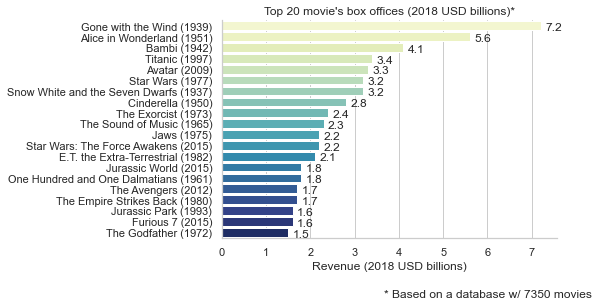

In [123]:
top_box_offices = complete_df
top_box_offices['revenue_usd_bi'] = top_box_offices['revenue'].apply(lambda x: round(x / 1000000000, 1))
top_box_offices['name_year'] = top_box_offices.apply(lambda x: x.original_title + " (" + str(x.year) + ")", axis = 1)
top_box_offices = top_box_offices.nlargest(20, 'revenue_usd_bi').loc[:,['name_year', 'revenue_usd_bi']]

def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = p.get_width()
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
        
g = sns.barplot(x="revenue_usd_bi", y="name_year", 
            data = top_box_offices, orient = "h", palette = "YlGnBu")

plt.title("Top 20 movie's box offices (2018 USD billions)*")
plt.xlabel("Revenue (2018 USD billions)")
plt.figtext(.5, -.08, "* Based on a database w/ 7350 movies")
plt.ylabel("")
sns.despine()


show_values_on_bars(g, "h", 0.1)

figtext(.02, .02, "This is text on the bottom of the figure.\nHere I've made extra room for adding more text.\n" + ("blah "*16+"\n")*3)#### Popularity

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.histplot(data = complete_df, x='popularity')
plt.ylabel("Absolute frequency")
plt.xlabel("Popularity")

plt.subplot(1, 2, 2)
sns.histplot(data = complete_df, x='ln_popularity')
plt.xlabel("Log-popularity")
plt.ylabel("Absolute frequency")
plt.show()

#### Runtime

In [ ]:
sns.histplot(data = complete_df, x = "runtime").set(title='Runtime variable histogram', xlabel='Runtime', ylabel='Count')
sns.despine()
plt.show()

Most of the movies are about 100 minutes long.

#### Cast and crew

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(complete_df['cast_size'])
ax1.set_title('Cast size histogram')
ax2.hist(complete_df['crew_size'])
ax2.set_title('Crew size histogram')
plt.show()

#### Production countries

In [ ]:
sns.countplot(x='prod_countries_USA', data=complete_df, palette = "YlGnBu")
plt.ylabel("Absolute frequency")
plt.xlabel("Was the movie produced in the USA?")
plt.show()

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='prod_countries_USA', y='ln_revenue', data=complete_df, palette = "YlGnBu")
plt.title('Log-revenue for USA x non-USA prod. countries')
plt.ylabel("Log-revenue")
plt.xlabel("Prod. country == USA")
sns.despine() # Removes some of the borders

# Second plot
plt.subplot(1, 2, 2)
sns.boxplot(x='prod_countries_other_top_10', y='ln_revenue', data=complete_df, palette = "YlGnBu")
plt.title('Log-revenue for other top 10 most common prod. countries')
plt.ylabel("Log-revenue")
plt.xlabel("Prod. country belongs to the other top 10 most frequent (USA incl.)?")
sns.despine()

In [ ]:
sns.boxplot(x='prod_countries_other_top_10', y='ln_revenue', data=complete_df.loc[complete_df['prod_countries_USA'] == 0], palette = "YlGnBu")
plt.title('Revenue for other top 10 most common prod. countries')
plt.ylabel("Log-revenue")
plt.xlabel("Prod. country belongs to the other top 10 most frequent (USA excl.)?")
sns.despine()

More than 80% of the movies were produced in the United States.

Movies produced in the United States show greater revenues than their counterparts. Movies made on the other top 10 countries have almost similar performance to those made outside them. However, when excluding the 'made in USA' films from the comparison, the other top 10 countries perfom better than their counterparts.

#### Homepage

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.countplot(x='has_homepage', data=complete_df, palette = "YlGnBu")
plt.ylabel("Absolute frequency")
plt.xlabel("Does the movie have a homepage?")

plt.subplot(1, 2, 2)
sns.boxplot(x='has_homepage', y='ln_revenue', data=complete_df, palette = "YlGnBu")
plt.title('Revenue comparison for movies with and without homepages')
plt.ylabel("Log-revenue")
plt.xlabel("Does the movie have a homepage?")
plt.show()

About two-thirds of the movies does not have a web homepage. Furthermore, as can be seen from the data, movies with homepages presents slightly higher revenues in comparison with those without website pages. However, the website itself probably is not a useful piece of information; therefore, this piece of information will be dropped later on.

#### Belongs to collection

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.countplot(x='has_collection', data=complete_df, palette = "YlGnBu")
plt.ylabel("Absolute frequency")
plt.xlabel("Movie belongs to collection?")

plt.subplot(1, 2, 2)
sns.boxplot(x='has_collection', y='ln_revenue', data=complete_df, palette = "YlGnBu")
plt.ylabel("Log-revenue")
plt.xlabel("Movie belongs to collection?")
plt.show()

Movies that are part of franchises shows higher revenues.

## Final prep

In [ ]:
# Drops useless variables
drop_list = ['id','imdb_id', 'original_title', 'original_language', 'status', 'poster_path',
                  'belongs_to_collection', 'homepage', 'spoken_languages', 'tagline', 'overview',
                  'prod_countries', 'prod_companies', 'crew', 'cast', 'genres',
                  'belongs_to_collection', 'Keywords', 'title', 'popularity','prod_countries_all',
                  'release_date', 'genres_count', 'release_weekday', 'release_quarter']

drop_list.append('revenue')
drop_list.append('budget')

df = complete_df.drop(drop_list,
                 axis = 1) # Axis = 1 means you're dropping a COLUMN, not a row

# Saving to excel file
df.to_excel('df.xlsx')
df.info()

# 3) Train-test split

**3)** Divida os dados em treino/teste: Sua base é balanceada? Você precisa pensar em alguma estratégia especial para dividir a sua base? Você considera estratégias como *K-fold validation*?

In [ ]:
# Splitting the data stratifying by "prod country == USA"
df_train, df_test = model_selection.train_test_split(df, test_size = 0.3, random_state = 0, stratify = df['prod_countries_USA'])
print("Proportion of movies produced in the USA in the train dataset: ", df_train['prod_countries_USA'].mean())
print("Proportion of movies produced in the USA in the test dataset: ", df_test['prod_countries_USA'].mean())

# 4) Benchmark model

**4)** Construa o seu *benchmark*. Sempre comece com modelo bem simples que você tenha controle. Uma boa escolha é um modelo linear em que  você consiga interpretar os seus resultados/ter uma ideia das variáveis que podem influenciar os seus resultados.

### Model

In [ ]:
class MySklearningModel:
    """ Object for the regression models. Accepts the use of PCA beforehand, and also
    has a method for running cross-validation
    """
    
    def __init__(self, model, df_train, df_test, independent_variable_list, dependent_variable, 
                 use_pca = False, pca_variance = 0.95):
        """ Initiates
        
        model: model's type
        df_train, df_test: train and test dataframes
        independent_variable_list: features (X variables)
        dependent_variable: target (y variable)
        use_pca: whether to use or not PCA for dimensionality reduction (default: false)
        pca_variance: explained variance threshold for the PCA. Goes from zero (0%) to one (100%) (default: 0.95)
        """
        self.model = model
        self.independent_variable_list = independent_variable_list
        self.dependent_variable = dependent_variable
        self.X_train, self.X_test = df_train[self.independent_variable_list].values, df_test[self.independent_variable_list].values
        self.y_train, self.y_test = np.squeeze(df_train[[self.dependent_variable]].values), np.squeeze(df_test[[self.dependent_variable]].values)
        self.pca_variance = pca_variance
        
        # Imputation
        imputer = IterativeImputer(max_iter=25, random_state=0)
        self.X_train = imputer.fit_transform(self.X_train)
        self.X_test = imputer.transform(self.X_test)
        
        # Dimensionality Reduction
        if use_pca == True:
            
            print("Initial number of dimensionalities: ", self.X_test.shape[1])
            
            # Rescaling before the PCA (necessary)
            my_scaler = StandardScaler()
            self.X_train = my_scaler.fit_transform(self.X_train) # Rescales train features
            self.X_test = my_scaler.transform(self.X_test) # Rescales test features
            
            pca = PCA(n_components = self.pca_variance)
            self.X_train = pca.fit_transform(self.X_train)
            self.X_test = pca.transform(self.X_test)
            
            print("Number of dimensionalities after PCA: ", self.X_test.shape[1])
            
        return None

    
    def run_sklearn_regression_crossval(self, number_splits, score_list, random_state = 0):
        """ Runs the regression (USE IT FOR CROSS-VALIDATION)
        
        number_splits: number of splits for the kfold
        score_list: performance's metrics to be used
        random_state: random seed (default = 0)
        """
        kfold = model_selection.KFold(n_splits=number_splits, shuffle=True, random_state=random_state)
        results = model_selection.cross_validate(self.model, self.X_train, self.y_train, cv=kfold, scoring=score_list,return_train_score=True)
        
        print(str(self.model))
        
        for score in score_list:
            print(score+':')
            print('Cross-val Train: '+'Mean',np.mean(results['train_'+score]),
            'Standard Error',np.std(results['train_'+score]))
            print('Cross-val Test: '+'Mean',np.mean(results['test_'+score]),
            'Standard Error',np.std(results['test_'+score]))
            print("")
            
    def run_sklearn_regression(self, score_list):
        """ Runs the regression """
        # Fits the model and predicts y
        self.model.fit(self.X_train, self.y_train)
        self.y_pred = self.model.predict(self.X_test)
        
        print(self.model)
    
        # Prints the performance metrics:
        for score in score_list:
            # If opted for MSE, returns RMSE
            if score == "mean_squared_error":
                print("root_" + score + ": " + str(eval(score + '(self.y_test, self.y_pred, squared = False)')))
            else:
                print(score + ": " + str(eval(score + '(self.y_test, self.y_pred)')))
        
        return None
    
    def prints_parameters(self):
        """ [NOT WORKING PROPERLY] Prints the model's parameters"""
        # Checks whether the model has already been fitted or not.
        if hasattr(self.model, 'coef_'):
            for i in range(len(self.independent_variable_list)):
                print(self.independent_variable_list[i] + ": " + str(self.model.coef_[i]))
        else:
            print("Model has not yet been fitted.")
        
        return None  

In [ ]:
if __name__ == '__main__':
    
    number_splits = 5
    
    dependent_variable = 'ln_revenue'
    independent_variable_list = df.columns.values
    independent_variable_list = [x for x in independent_variable_list if x != dependent_variable]
    
    for model in [LinearRegression(), KNeighborsRegressor(n_neighbors = 10),
                  RandomForestRegressor(n_estimators = 100, max_depth = 11, random_state = 0)]:
        
        my_model = MySklearningModel(model,df_train, df_test, independent_variable_list,dependent_variable, 
                                     use_pca = False, pca_variance = 0.95)
        
        # Cross-validation
        #my_model.run_sklearn_regression_crossval(number_splits, ['neg_mean_squared_error', 'r2'])
        
        # Regression
        my_model.run_sklearn_regression(['mean_squared_error', 'r2_score', 'mean_squared_log_error'])
        
        print("\n\n")

****

In [ ]:
"""
if __name__ == '__main__':
    
    number_splits=5
    
    dependent_variable = 'ln_revenue'
    independent_variable_list = df.columns.values
    independent_variable_list = [x for x in independent_variable_list if x != dependent_variable]
    
    for i in range(1, 32):
        print("Max_depth: ", i)
        
        model = RandomForestRegressor(n_estimators = 100, max_depth = 11, random_state = 0)
        my_model = MySklearningModel(model,df_train, df_test,
        independent_variable_list,dependent_variable)
        
        my_model.run_sklearn_regression_crossval(number_splits,
        ['neg_mean_squared_error', 'r2'])
        #my_model.run_sklearn_regression(['mean_squared_error', 'r2_score'])
        print("\n\n")
"""

Using cross-validation, I opted to run the KNeighbors Regressor using n = 10 neighbors. After this threshold, the gains on the tests' scores were marginal. Also, for the Random Forest Regressor, the optimal parameters I found were n_estimators = 100 and max_depth = 11.